In [9]:
import torch
import pyreadstat
import os
import pickle
import random

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from PIL import Image
from transformers import AutoModel, AutoTokenizer


In [2]:
df, meta = pyreadstat.read_sav('final_upperarm_dataset.sav')
print(df.shape)
mapping = {
    '1': 'N',
    '2': 'UV',
    '3': '415_Y',
    '4': '415_O',
    '5': '450_Y',
    '6': '450_O',
    '7': '475_O',
    '8': '495_O',
    '9': '515_O',
    '10': '515_R',
    '11': '535_R'
}
df['WL_text'] = df['WL'].map(mapping)
df['file_name'] = df.apply(lambda row: f"{row['Subject']}_V{int(row['Visit'])}_UA_{row['WL_text']}.jpg", axis=1)

(31841, 108)


In [3]:
y = ['PAINTBALL_AGE_HR']
a_columns = ['file_name',
             'Gender',
             'RACE',
             'Hair_color',
             'Dominant_hand',
             'BMI',
             'HT_METER',
             'WGHT_KG',
             'WL', #wave length including whitelight and UV
             # 'BVS', #how visible is the bruise?
             # 'brsize', #size of the bruise
             'UA_bruise_L',
             'UA_bruise_a',
             'UA_bruise_b',
             'UA_around_L',
             'UA_around_a',
             'UA_around_b',
             'DELTA_E_UPPER',
             'UA_opposite_L',
             'UA_opposite_a',
             'UA_opposite_b',
             # 'LUA_base_L',
             # 'LUA_base_a',
             # 'LUA_base_b',
             # 'RUA_base_L',
             # 'RUA_base_a',
             # 'RUA_base_b',
             'UA_Random', 
             'Paintball_Pain',
             'UA_L',
             'UA_a',
             'UA_b',
             'ITA',
             'Skin_Color',
             # 'RUA_Circ',
             # 'RUA_Skinfold',
             # 'LUA_Circ',
             # 'LUA_Skinfold',
             'AC_UPPER',
             'SF_UPPER',
             'AA_UPPER',
             'AMA_UPPER',
             'AFA_UPPER',
             'AFI_UP']
b_columns = ['Race_other_txt',
             'Hair_other_txt',
             'ALSup', #0:white light 1:ASL
             'visibility', #1: bruise is visible 0: bruise is not visible
             'Abrasion',
             'Abr_Location',
             'Abr_iden']

df = df[y+a_columns]
print(f'Number of features is {df.shape[1]}')
df.dropna(subset=['RACE'], inplace=True)
df.dropna(inplace=True)

Number of features is 33


In [4]:
df = pd.get_dummies(df, columns=['Gender','RACE','Hair_color','Dominant_hand','WL','Skin_Color'], dtype='float')
print(f'Number of features including one-hot-encoded is {df.shape[1]}')

Number of features including one-hot-encoded is 60


In [5]:
def normalize_columns(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

df = normalize_columns(df, ['BMI', 'HT_METER', 'WGHT_KG', 'UA_bruise_L', 'UA_bruise_a', 'UA_bruise_b', 'UA_around_L', 'UA_around_a', 'UA_around_b', 'DELTA_E_UPPER',
         'UA_opposite_L', 'UA_opposite_a', 'UA_opposite_b', 'UA_Random', 'Paintball_Pain', 'UA_L', 'UA_a', 'UA_b', 'ITA', 'AC_UPPER','SF_UPPER', 'AA_UPPER',
         'AMA_UPPER', 'AFA_UPPER', 'AFI_UP'])
# df1 = normalize_columns(df1, df1.columns.to_list())

In [6]:
y = df[['PAINTBALL_AGE_HR']].astype(np.float32).values
X = x = df.drop(columns=['PAINTBALL_AGE_HR', 'file_name']).astype(np.float32).values

# 1. Using structured data to train a NN regression model

In [7]:
# defining dataset and NN model

class TabularDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32).view(-1, 1) 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SimpleRegressor(nn.Module):
    def __init__(self, input_dim=58):
        super(SimpleRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.out(x)

In [8]:
# training the model

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.15, random_state=42)

train_dataset = TabularDataset(X_train, y_train)
val_dataset = TabularDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

model = SimpleRegressor(input_dim=58)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 140
losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
    losses.append([train_loss, val_loss])


Epoch 1/140 - Train Loss: 48836.4135 - Val Loss: 44452.8347
Epoch 2/140 - Train Loss: 41619.5673 - Val Loss: 35281.7275
Epoch 3/140 - Train Loss: 33440.9526 - Val Loss: 31609.5430
Epoch 4/140 - Train Loss: 31565.9318 - Val Loss: 30379.2647
Epoch 5/140 - Train Loss: 30536.6801 - Val Loss: 29147.6929
Epoch 6/140 - Train Loss: 29713.2437 - Val Loss: 28844.2364
Epoch 7/140 - Train Loss: 29035.7265 - Val Loss: 27857.2341
Epoch 8/140 - Train Loss: 28630.7930 - Val Loss: 28554.0100
Epoch 9/140 - Train Loss: 28001.6500 - Val Loss: 27115.2047
Epoch 10/140 - Train Loss: 27727.6258 - Val Loss: 26839.2007
Epoch 11/140 - Train Loss: 27362.9305 - Val Loss: 26779.0121
Epoch 12/140 - Train Loss: 27059.9218 - Val Loss: 26825.0859
Epoch 13/140 - Train Loss: 26915.8157 - Val Loss: 26255.8259
Epoch 14/140 - Train Loss: 26501.7918 - Val Loss: 26136.8670
Epoch 15/140 - Train Loss: 26322.7804 - Val Loss: 25983.7766
Epoch 16/140 - Train Loss: 25990.3815 - Val Loss: 25437.7815
Epoch 17/140 - Train Loss: 25917.

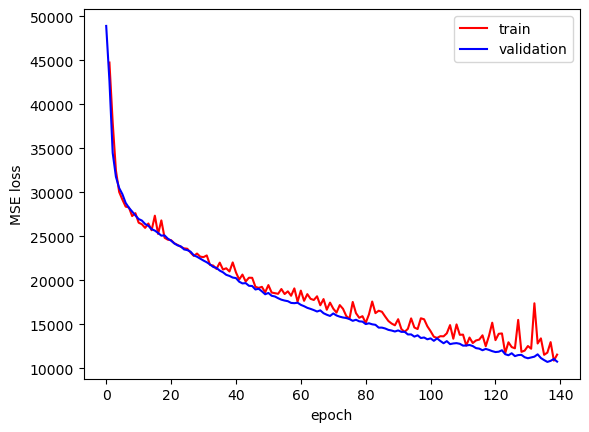

In [16]:
# with open('reg_fc_txt_1e-3.pkl', 'rb') as file:
#     model, losses = pickle.load(file)

plt.plot([None]+[v[1] for v in losses][:-1], c='red', label='train')
plt.plot([v[0] for v in losses], c='blue', label='validation')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend(loc='upper right')

In [30]:
torch.mean((model(torch.tensor(X_val))-torch.tensor(y_val)))

tensor(6.1522, grad_fn=<MeanBackward0>)

In [333]:
#k-fold cross validation of the model

def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate_model(model, val_loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            output = model(data).squeeze().cpu().numpy()
            preds.extend(output)
            targets.extend(target.numpy())
    return mean_squared_error(targets, preds)

def k_fold_train(X, y, k=10, epochs=140, batch_size=32, learning_rate=1e-3):
    device = torch.device("cpu")
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold+1}/{k}")
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                 torch.tensor(y_train, dtype=torch.float32))
        val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                               torch.tensor(y_val, dtype=torch.float32))

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=batch_size)

        model = SimpleRegressor(input_dim=X.shape[1]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            train_model(model, train_loader, criterion, optimizer, device)

        mse = evaluate_model(model, val_loader, device)
        print(f"Fold {fold+1} MSE: {mse:.4f}")
        mse_scores.append(mse)

    print(f"\nAverage MSE across {k} folds: {np.mean(mse_scores):.4f}")
    return mse_scores

In [ ]:
mse_scores = k_fold_train(X, y, k=10, epochs=140, batch_size=32, learning_rate=1e-3)

# 2. Training a CNN regression model to be trained on image dataset

In [41]:
# CNN regression model
class DeepImageRegressor(nn.Module):
    def __init__(self):
        super(DeepImageRegressor, self).__init__()
        
        # Feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.regressor = nn.Sequential(
            nn.Flatten(),              
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)          
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x.squeeze(1)  

In [11]:
# CNN regresion dataset
class ImageRegressionDataset(Dataset):
    def __init__(self, image_df, root_dir, transform=None):

        self.annotations = image_df
        self.root_dir = root_dir
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(float(self.annotations.iloc[idx, 1]), dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
image_df = df[['file_name', 'PAINTBALL_AGE_HR']]
root_dir = os.path.join(os.getcwd(), 'images')
imageNames = os.listdir('images')

image_df = pd.merge(pd.DataFrame(imageNames), image_df, how='left', left_on=0, right_on='file_name').drop(0, axis= 1).dropna()
# image_df.drop(0, inplace=True)
image_df

,file_name,PAINTBALL_AGE_HR
0,GM002_V11_UA_415_O.jpg,99.17
1,GM002_V11_UA_415_Y.jpg,99.17
2,GM002_V11_UA_450_O.jpg,99.17
3,GM002_V11_UA_450_Y.jpg,99.17
4,GM002_V11_UA_475_O.jpg,99.17
...,...,...
19822,TAM105_V2_UA_N.jpg,6.97
19823,TAM105_V5_UA_495_O.jpg,30.30
19824,TAM105_V5_UA_N.jpg,30.30
19825,TAM105_V7_UA_N.jpg,47.72


In [13]:
transform = transforms.Compose([
    # transforms.Resize((640, 640)),  # Ensure fixed input size
    transforms.Resize((320, 320)),  # Ensure fixed input size
    transforms.ToTensor()
])

dataset = ImageRegressionDataset(image_df=image_df, root_dir=root_dir, transform=transform)

# Optional train/val split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


In [ ]:
#CNN regression model training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepImageRegressor().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Train Loss: {epoch_loss:.4f}")

    # Optional: validation loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")
    losses.append([epoch_loss, val_loss])

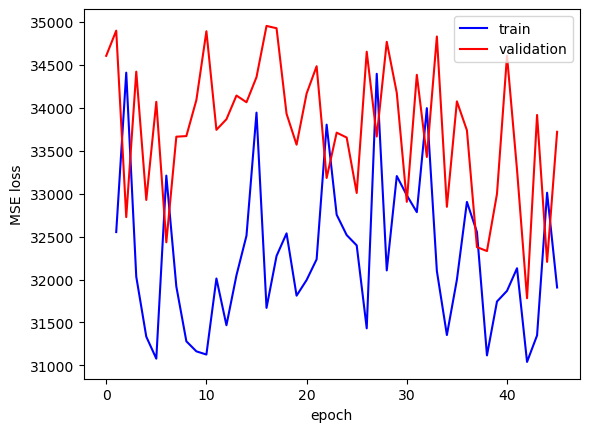

In [467]:
plt.plot([None]+[v[1] for v in losses][:-1], c='blue', label='train')
plt.plot([v[0] for v in losses], c='red', label='validation')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend(loc='upper right')

In [444]:
filename = 'AE_CNN_img_1e-3_random.pkl'

with open(filename, 'wb') as file:
    pickle.dump((model, losses), file)

In [10]:
#experimenting with a pretrianed model

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

C:\Users\mghyabi\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mghyabi\AppData\Local\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\mghyabi/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [ ]:
#transfer learning using pre-trained model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 20
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))  # Adjust target shape if needed
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Train Loss: {epoch_loss:.4f}")
    losses.append(epoch_loss)

# 3. Using pretrained BERT encoders to get text fewatures for further usage

In [3]:

df, meta = pyreadstat.read_sav('final_upperarm_dataset.sav')
mapping = {
    '1': 'N',
    '2': 'UV',
    '3': '415_Y',
    '4': '415_O',
    '5': '450_Y',
    '6': '450_O',
    '7': '475_O',
    '8': '495_O',
    '9': '515_O',
    '10': '515_R',
    '11': '535_R'
}
df['WL_text'] = df['WL'].map(mapping)
df['file_name'] = df.apply(lambda row: f"{row['Subject']}_V{int(row['Visit'])}_UA_{row['WL_text']}.jpg", axis=1)

y = ['PAINTBALL_AGE_HR']
a_columns = ['file_name',
             'Gender',
             'RACE',
             'Hair_color',
             'Dominant_hand',
             'BMI',
             'HT_METER',
             'WGHT_KG',
             'WL', #wave length including whitelight and UV
             'BVS', #how visible is the bruise?
             'brsize', #size of the bruise
             # 'UA_bruise_L',
             # 'UA_bruise_a',
             # 'UA_bruise_b',
             # 'UA_around_L',
             # 'UA_around_a',
             # 'UA_around_b',
             'DELTA_E_UPPER',
             # 'UA_opposite_L',
             # 'UA_opposite_a',
             # 'UA_opposite_b',
             # 'LUA_base_L',
             # 'LUA_base_a',
             # 'LUA_base_b',
             # 'RUA_ base_L',
             # 'RUA_ base_a',
             # 'RUA_ base_b',
             # 'UA_Random', 
             'Paintball_Pain',
             # 'UA_L',
             # 'UA_a',
             # 'UA_b',
             'ITA',
             'Skin_Color',
             # 'RUA_Circ',
             # 'RUA_Skinfold',
             # 'LUA_Circ',
             # 'LUA_Skinfold',
             'AC_UPPER',
             'SF_UPPER',
             'AA_UPPER',
             'AMA_UPPER',
             'AFA_UPPER',
             'AFI_UP']

# df = df[y+a_columns]
df = df[a_columns]
df.dropna(subset=['RACE'], inplace=True)
df.dropna(inplace=True)

root_dir = os.path.join(os.getcwd(), 'images')
imageNames = os.listdir('images')

merge_df = pd.merge(pd.DataFrame(imageNames), df, how='left', left_on=0, right_on='file_name').drop(0, axis= 1).dropna()
merge_df

,file_name,Gender,RACE,Hair_color,Dominant_hand,BMI,HT_METER,WGHT_KG,WL,BVS,...,DELTA_E_UPPER,Paintball_Pain,ITA,Skin_Color,AC_UPPER,SF_UPPER,AA_UPPER,AMA_UPPER,AFA_UPPER,AFI_UP
0,GM002_V11_UA_415_O.jpg,1.0,1.0,1.0,1.0,20.528922,1.8200,68.0,4,2.785,...,2.498800,4.0,-8.1,5.0,28.6,1.7,65.091189,33.050989,32.040199,49.223558
1,GM002_V11_UA_415_Y.jpg,1.0,1.0,1.0,1.0,20.528922,1.8200,68.0,3,3.278,...,2.498800,4.0,-8.1,5.0,28.6,1.7,65.091189,33.050989,32.040199,49.223558
2,GM002_V11_UA_450_O.jpg,1.0,1.0,1.0,1.0,20.528922,1.8200,68.0,6,2.836,...,2.498800,4.0,-8.1,5.0,28.6,1.7,65.091189,33.050989,32.040199,49.223558
3,GM002_V11_UA_450_Y.jpg,1.0,1.0,1.0,1.0,20.528922,1.8200,68.0,5,2.014,...,2.498800,4.0,-8.1,5.0,28.6,1.7,65.091189,33.050989,32.040199,49.223558
4,GM002_V11_UA_475_O.jpg,1.0,1.0,1.0,1.0,20.528922,1.8200,68.0,7,2.303,...,2.498800,4.0,-8.1,5.0,28.6,1.7,65.091189,33.050989,32.040199,49.223558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19820,TAM105_V18_UA_450_Y.jpg,0.0,2.0,3.0,0.0,28.791542,1.7272,85.9,5,2.707,...,1.593675,8.0,-33.5,6.0,33.5,1.3,89.305817,62.358140,26.947677,30.174604
19822,TAM105_V2_UA_N.jpg,0.0,2.0,3.0,0.0,28.791542,1.7272,85.9,1,1.411,...,3.020546,8.0,-33.5,6.0,33.5,1.3,89.305817,62.358140,26.947677,30.174604
19823,TAM105_V5_UA_495_O.jpg,0.0,2.0,3.0,0.0,28.791542,1.7272,85.9,8,2.211,...,2.412986,8.0,-33.5,6.0,33.5,1.3,89.305817,62.358140,26.947677,30.174604
19824,TAM105_V5_UA_N.jpg,0.0,2.0,3.0,0.0,28.791542,1.7272,85.9,1,2.944,...,2.412986,8.0,-33.5,6.0,33.5,1.3,89.305817,62.358140,26.947677,30.174604


In [4]:
cs = ['Gender','RACE','Hair_color','Dominant_hand','WL', 'Skin_Color']

mapping_dict = {'Skin_Color': {1: 'skin: very light', 2: 'skin: light', 3: 'skin: intermediate', 4: 'skin: tan', 5: 'skin: brown', 6: 'skin: dark'},
                'WL': {'1': 'wavelength: white light', '2': 'wavelength: uv', '3': 'wavelength: 415 y', '4': 'wavelength: 415 o', '5': 'wavelength: 450 y', '6': 'wavelength: 450 o', '7': 'wavelength: 475 o', '8': 'wavelength: 495 o', '9': 'wavelength: 515 o', '10': 'wavelength: 515 r', '11': 'wavelength: 535 r'},
                'Dominant_hand': {0: 'hand: left', 1: 'hand: right', 2: 'hand: ambidextrous', 99: 'hand: unknown'},
                'Hair_color': {1: 'hair: black', 2: 'hair: blonde', 3: 'hair: brown', 4: 'hair: grey', 5: 'hair: red', 6: 'hair: other', 98: 'hair: unknown', 99: 'hair: unknown'},
                'RACE': {1: 'race: asian', 2: 'race: black', 3: 'race: cauicasion', 4: 'race: hispanic', 5: 'race: native', 6: 'race: multiracial', 7: 'race: other', 99: 'race: unknown'},
                'Gender': {0: 'gender: female', 1: 'gender: male'},
               }
for c in mapping_dict:
    merge_df[c] = merge_df[c].map(mapping_dict[c])

merge_df['WGHT_KG'] = 'weight: ' + merge_df['WGHT_KG'].astype(str)
merge_df['BMI'] = 'bmi: ' + merge_df['BMI'].round(2).astype(str)
merge_df['HT_METER'] = 'height: ' + merge_df['HT_METER'].round(2).astype(str)
merge_df['ITA'] = 'typology: ' + merge_df['ITA'].round(1).astype(str)
merge_df['AC_UPPER'] = 'circumference: ' + merge_df['AC_UPPER'].round(1).astype(str)
merge_df['SF_UPPER'] = 'skinfold: ' + merge_df['SF_UPPER'].round(1).astype(str)
merge_df['AA_UPPER'] = 'area: ' + merge_df['AA_UPPER'].round(2).astype(str)
merge_df['AMA_UPPER'] = 'muscle: ' + merge_df['AMA_UPPER'].round(2).astype(str)
merge_df['AFA_UPPER'] = 'fat: ' + merge_df['AFA_UPPER'].round(2).astype(str)
merge_df['AFI_UP'] = 'ratio: ' + merge_df['AFI_UP'].round(2).astype(str)
merge_df['Paintball_Pain'] = 'pain: ' + merge_df['Paintball_Pain'].round(0).astype(str)
merge_df['DELTA_E_UPPER'] = 'difference: ' + merge_df['DELTA_E_UPPER'].round(2).astype(str)
merge_df['BVS'] = 'visibility: ' + merge_df['BVS'].round(2).astype(str)
merge_df['brsize'] = 'size: ' + merge_df['brsize'].round(2).astype(str)

merge_df.drop('file_name', axis=1, inplace=True)

merge_df.dtypes

Gender            object
RACE              object
Hair_color        object
Dominant_hand     object
BMI               object
HT_METER          object
WGHT_KG           object
WL                object
BVS               object
brsize            object
DELTA_E_UPPER     object
Paintball_Pain    object
ITA               object
Skin_Color        object
AC_UPPER          object
SF_UPPER          object
AA_UPPER          object
AMA_UPPER         object
AFA_UPPER         object
AFI_UP            object
dtype: object

In [5]:
random.seed(42)

is_order_random = True

combined_strings = []

for _, row in merge_df.iterrows():
    strings = list(row.values)  
    if is_order_random:
        random.shuffle(strings)     
    combined = ' '.join(strings) 
    combined_strings.append(combined)

combined_strings

['typology: 36.3 skin: intermediate hair: blonde size: 604.76 bmi: 21.45 weight: 53.2 visibility: 4.83 hand: right wavelength: 415 y gender: female race: cauicasion pain: 5.0',
 'skin: very light typology: 60.0 hair: brown bmi: 19.95 pain: 7.0 weight: 51.1 wavelength: 415 y size: 530.14 hand: right race: cauicasion visibility: 4.48 gender: female',
 'size: 1099.56 pain: 6.0 skin: very light hair: blonde visibility: 3.44 race: cauicasion weight: 67.3 gender: male wavelength: 415 y bmi: 23.24 typology: 57.1 hand: right',
 'visibility: 2.32 size: 549.78 typology: 0.8 wavelength: uv pain: 4.0 hair: black gender: male weight: 120.3 bmi: 33.15 race: asian skin: brown hand: right']

In [480]:
model_name = "prajjwal1/bert-mini"
model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [483]:
text_features = []
for s in combined_strings:
    inputs = tokenizer(s, return_tensors="pt")
    outputs = model(**inputs)
    text_features.append(outputs)

In [398]:
filename = 'merge_fc_1e-1.pkl'

with open(filename, 'wb') as file:
    pickle.dump((model, losses), file)

# 4. Training an AE to use the encoder part for image feature extraction

In [46]:
# AE model
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 20 * 20, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 20 * 20),
            nn.ReLU(),
            nn.Unflatten(1, (256, 20, 20)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [ ]:
# AE training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder(latent_dim=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

num_epochs = 15
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for inputs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")
    losses.append(avg_loss)


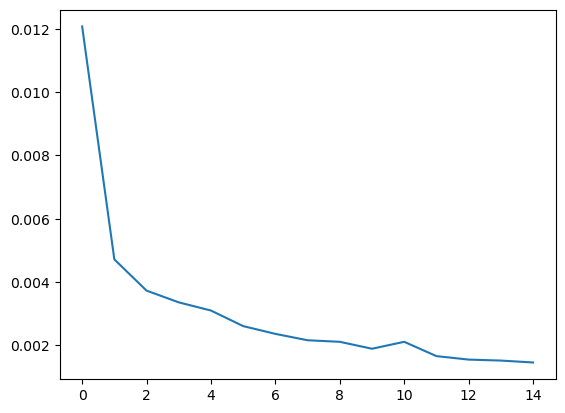

In [59]:
plt.plot(losses)

# 5. Getting image features from AE encoder block

In [ ]:
with open('AE_CNN_img_1e-3.pkl', 'rb') as file:
    ae_model = pickle.load(file)[0]

In [ ]:
df, meta = pyreadstat.read_sav('final_upperarm_dataset.sav')
mapping = {
    '1': 'N',
    '2': 'UV',
    '3': '415_Y',
    '4': '415_O',
    '5': '450_Y',
    '6': '450_O',
    '7': '475_O',
    '8': '495_O',
    '9': '515_O',
    '10': '515_R',
    '11': '535_R'
}
df['WL_text'] = df['WL'].map(mapping)
df['file_name'] = df.apply(lambda row: f"{row['Subject']}_V{int(row['Visit'])}_UA_{row['WL_text']}.jpg", axis=1)

y = ['PAINTBALL_AGE_HR']
a_columns = ['file_name',
             'Gender',
             'RACE',
             'Hair_color',
             'Dominant_hand',
             'BMI',
             'HT_METER',
             'WGHT_KG',
             'WL', #wave length including whitelight and UV
             'BVS', #how visible is the bruise?
             'brsize', #size of the bruise
             # 'UA_bruise_L',
             # 'UA_bruise_a',
             # 'UA_bruise_b',
             # 'UA_around_L',
             # 'UA_around_a',
             # 'UA_around_b',
             'DELTA_E_UPPER',
             # 'UA_opposite_L',
             # 'UA_opposite_a',
             # 'UA_opposite_b',
             # 'LUA_base_L',
             # 'LUA_base_a',
             # 'LUA_base_b',
             # 'RUA_ base_L',
             # 'RUA_ base_a',
             # 'RUA_ base_b',
             # 'UA_Random', 
             'Paintball_Pain',
             # 'UA_L',
             # 'UA_a',
             # 'UA_b',
             'ITA',
             'Skin_Color',
             # 'RUA_Circ',
             # 'RUA_Skinfold',
             # 'LUA_Circ',
             # 'LUA_Skinfold',
             'AC_UPPER',
             'SF_UPPER',
             'AA_UPPER',
             'AMA_UPPER',
             'AFA_UPPER',
             'AFI_UP']

df = df[y+a_columns]
# df = df[a_columns]
df.dropna(subset=['RACE'], inplace=True)
df.dropna(inplace=True)

root_dir = os.path.join(os.getcwd(), 'images')
imageNames = os.listdir('images')

merge_df = pd.merge(pd.DataFrame(imageNames), df, how='left', left_on=0, right_on='file_name').drop(0, axis= 1).dropna()
merge_df

In [497]:
merge_df = merge_df[['file_name', 'PAINTBALL_AGE_HR']]
merge_df

,file_name,PAINTBALL_AGE_HR
0,GM002_V11_UA_415_O.jpg,99.17
1,GM002_V11_UA_415_Y.jpg,99.17
2,GM002_V11_UA_450_O.jpg,99.17
3,GM002_V11_UA_450_Y.jpg,99.17
4,GM002_V11_UA_475_O.jpg,99.17
...,...,...
19820,TAM105_V18_UA_450_Y.jpg,513.17
19822,TAM105_V2_UA_N.jpg,6.97
19823,TAM105_V5_UA_495_O.jpg,30.30
19824,TAM105_V5_UA_N.jpg,30.30


In [300]:
root_dir = os.path.join(os.getcwd(), 'images')

dataset = ImageRegressionDataset(image_df=merge_df.iloc, root_dir=root_dir, transform=transform)

data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

img_features = []
with torch.no_grad():
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = ae_model.encoder(inputs)
        img_features.append(outputs)


# 6. Using both text and image features to train the regression model

In [439]:
device = torch.device("cpu")

data = []
for i in range(len(text_features)):
    data.append(torch.tensor(text_features[i] + img_features[i][0].tolist(), dtype=torch.float32))


targets = torch.tensor(merge_df[['PAINTBALL_AGE_HR']].astype(np.float32).values.squeeze()).to(device)

In [440]:
class TensorDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

full_dataset = TensorDataset(data, targets)

train_size = int(0.9 * len(full_dataset))  
val_size = len(full_dataset) - train_size  
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [434]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  
        )

    def forward(self, x):
        return self.model(x)

In [441]:
lr = 1e-3
epochs = 50

model = Regressor()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    losses.append((avg_train_loss, avg_val_loss))

C:\Users\mghyabi\AppData\Local\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50] - Train Loss: 31305.8649, Validation Loss: 28459.3438
Epoch [2/50] - Train Loss: 26581.4468, Validation Loss: 27117.1520
Epoch [3/50] - Train Loss: 24740.5297, Validation Loss: 24951.0082
Epoch [4/50] - Train Loss: 22210.9656, Validation Loss: 22867.8494
Epoch [5/50] - Train Loss: 18569.9630, Validation Loss: 20075.3472
Epoch [6/50] - Train Loss: 14687.9810, Validation Loss: 18821.2231
Epoch [7/50] - Train Loss: 11827.0502, Validation Loss: 17080.9802
Epoch [8/50] - Train Loss: 9051.5139, Validation Loss: 15455.4279
Epoch [9/50] - Train Loss: 7071.3533, Validation Loss: 15367.9188
Epoch [10/50] - Train Loss: 5508.9083, Validation Loss: 14712.5943
Epoch [11/50] - Train Loss: 4453.4294, Validation Loss: 13730.5420
Epoch [12/50] - Train Loss: 3678.0673, Validation Loss: 14834.9046
Epoch [13/50] - Train Loss: 5412.4564, Validation Loss: 13497.5747
Epoch [14/50] - Train Loss: 2773.0718, Validation Loss: 12688.0240
Epoch [15/50] - Train Loss: 2163.8473, Validation Loss: 12743.14

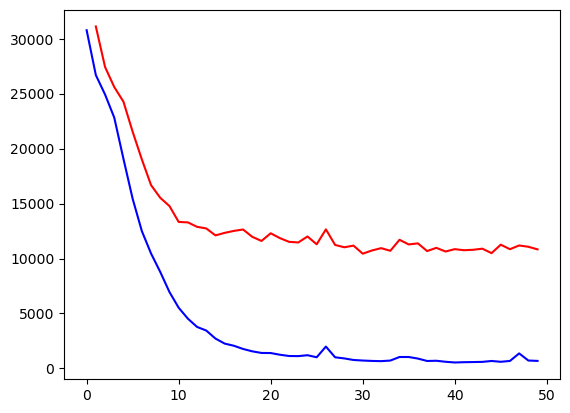

In [436]:

# v
plt.plot([None]+[v[1] for v in losses][:-1], c='red')
plt.plot([v[0] for v in losses], c='blue')

In [ ]:
with open('merge_fc_1e-1.pkl', 'rb') as file:
    model, losses = pickle.load(file)[0]


plt.plot([None]+[v[1] for v in losses][:-1], c='blue', label='train')
plt.plot([v[0] for v in losses], c='red', label='validation')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend(loc='upper right')

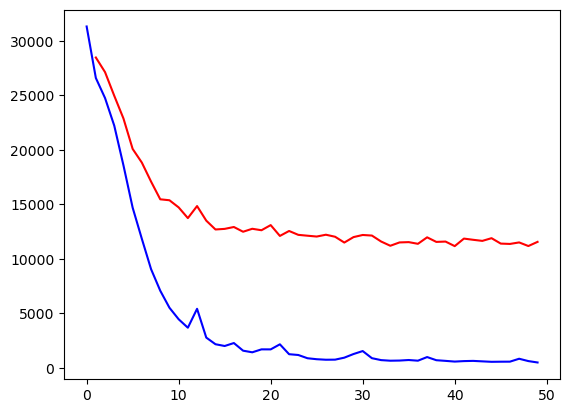

In [442]:

# v
plt.plot([None]+[v[1] for v in losses][:-1], c='red')
plt.plot([v[0] for v in losses], c='blue')

In [445]:
outputs = []
for d in val_dataset:
    outputs.append(torch.abs(model(d[0])-d[1]))

In [433]:
sum(outputs)/len(outputs)

tensor([50.3723], grad_fn=<DivBackward0>)

In [446]:
sum(outputs)/len(outputs)

tensor([55.7577], grad_fn=<DivBackward0>)

In [438]:
with open('txt_features_random.pkl', 'rb') as file:
    text_features = pickle.load(file)

# 7. Training a regression model using text features extracted by BERT

In [509]:
with open('txt_features.pkl', 'rb') as file:
    text_features = pickle.load(file)


device = torch.device("cpu")

data = []
for i in range(len(text_features)):
    data.append(torch.tensor(text_features[i], dtype=torch.float32))


targets = torch.tensor(merge_df[['PAINTBALL_AGE_HR']].astype(np.float32).values.squeeze()).to(device)

In [499]:
class TensorDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

full_dataset = TensorDataset(data, targets)

train_size = int(0.9 * len(full_dataset))  
val_size = len(full_dataset) - train_size  
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [500]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
lr = 1e-3
epochs = 50

model = Regressor()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    losses.append((avg_train_loss, avg_val_loss))

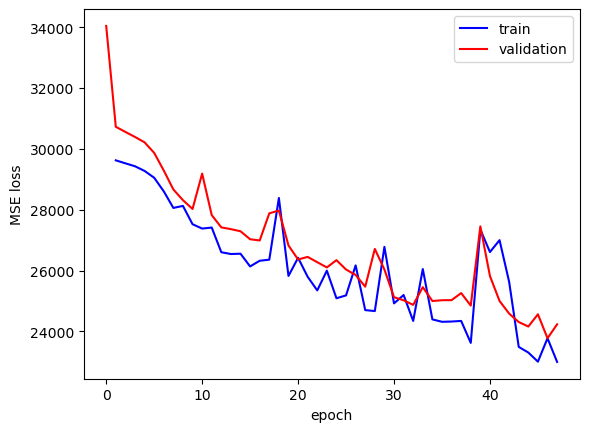

In [515]:
plt.plot([None]+[v[1] for v in losses][:-3], c='blue', label='train')
plt.plot([v[0] for v in losses[:-2]], c='red', label='validation')

plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.legend(loc='upper right')

In [453]:
outputs = []
for d in val_dataset:
    outputs.append(torch.abs(model(d[0])-d[1]))

sum(outputs)/len(outputs)

tensor([119.4912], grad_fn=<DivBackward0>)

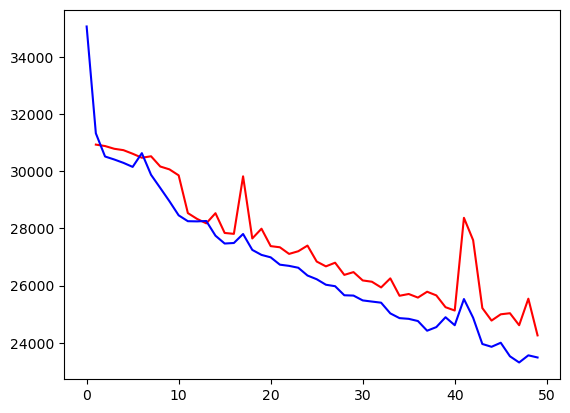

In [458]:
plt.plot([None]+[v[1] for v in losses][:-1], c='red')
plt.plot([v[0] for v in losses], c='blue')

In [459]:
outputs = []
for d in val_dataset:
    outputs.append(torch.abs(model(d[0])-d[1]))

sum(outputs)/len(outputs)

tensor([116.5219], grad_fn=<DivBackward0>)